# Import relevant libraries

In [1]:
# Import relevant libraries

from collections import Counter
import datetime
import matplotlib.pyplot as plt
#from nltk import ngrams
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from scipy.stats import chi2_contingency
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison


# Settings for seaborn plots
sns.set(rc={'figure.figsize':(10, 10)})
sns.set_theme(style='white')

# Import data from .csv file

In [2]:
# Read data from .csv file|
df_inc_raw = pd.read_csv('ny_accidents.csv', sep=',', decimal=',', engine='python') # Read the data from a csv

# Pre-processing

## Checking full number of rows

In [3]:
df_inc_row_count = df_inc_raw.shape[0] # number of rows pre-processing
print(f'The full nuber of rows is: {df_inc_row_count}')

The full nuber of rows is: 39537


## Checking number of rows with NaN values

In [4]:
# Code for finding number of missing values in a row
df_inc_raw.isnull().sum()

Unnamed: 0                   0
ID                           0
Severity                     0
Start_Time                   0
End_Time                     0
Start_Lat                    0
Start_Lng                    0
End_Lat                      0
End_Lng                      0
Distance.mi.                 0
Description                  0
Number                   27692
Street                       0
Side                         0
City                         8
County                       0
State                        0
Zipcode                      0
Country                      0
Timezone                     0
Airport_Code                66
Weather_Timestamp          312
Temperature.F.             390
Wind_Chill.F.             1463
Humidity...                400
Pressure.in.               375
Visibility.mi.             406
Wind_Direction             939
Wind_Speed.mph.           1188
Precipitation.in.         1943
Weather_Condition          343
Amenity                      0
Bump    

## Removing unneeded rows and columns

### Selecting only columns with desired variables

In [5]:
df_inc = df_inc_raw[['Severity', 'Start_Time', 'End_Time', 'Distance.mi.', 'Side',
                    'City', 'County', 'Temperature.F.', 'Wind_Chill.F.', 'Humidity...', 'Pressure.in.',
                    'Visibility.mi.', 'Wind_Speed.mph.', 'Precipitation.in.', 'Weather_Condition', 'Amenity',
                    'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
                    'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset']].copy()

### Remove rows with missing values

In [6]:
df_inc = df_inc.dropna()
df_inc.reset_index(drop = True, inplace = True) # reset row index after excluding rows with missing values

## Renaming data

### Rename columns for convenience

In [7]:
df_inc.rename(columns = {'Distance.mi.':'Distance',
                        'Temperature.F.':'Temp',
                        'Wind_Chill.F.':'Wind_Chill',
                        'Humidity...':'Humidity',
                        'Pressure.in.':'Air_Pressure',
                        'Visibility.mi.':'Vis',
                        'Wind_Speed.mph.':'Wind_Speed',
                        'Precipitation.in.':'Precip',
                        'Weather_Condition':'Weather',
                        'Sunrise_Sunset':'Daytime'},
                        inplace = True)

### Aggregate and rename values in 'Weather' column

In [8]:
# Rename and summarize values of 'Weather' column for convenience
df_inc['Weather'] = df_inc['Weather'].replace({'Fair / Windy':'Fair', 'Clear':'Fair'})
df_inc['Weather'] = df_inc['Weather'].replace({'Mostly Cloudy':'Cloudy', 'Partly Cloudy':'Cloudy', 'Cloudy / Windy':'Cloudy', 'Mostly Cloudy / Windy':'Cloudy', 'Partly Cloudy / Windy':'Cloudy', 'Scattered Clouds':'Cloudy'})
df_inc['Weather'] = df_inc['Weather'].replace({'Patches of Fog':'Fog','Shallow Fog':'Fog', 'Fog / Windy':'Fog', 'Patches of Fog / Windy':'Fog', 'Light Freezing Fog':'Fog'})
df_inc['Weather'] = df_inc['Weather'].replace({'Light Rain':'Rain','Light Rain / Windy':'Rain', 'Light Drizzle':'Rain', 'Light Rain with Thunder':'Rain', 'Heavy Rain':'Rain', 'Drizzle':'Rain', 'Rain / Windy':'Rain', 'Heavy Rain / Windy':'Rain', 'Drizzle and Fog':'Rain', 'Light Drizzle / Windy':'Rain', 'Light Freezing Rain':'Rain', 'Light Freezing Drizzle':'Rain'})
df_inc['Weather'] = df_inc['Weather'].replace({'Light Snow / Windy':'Snow', 'Light Snow':'Snow', 'Heavy Snow':'Snow', 'Heavy Snow / Windy':'Snow', 'Snow and Sleet / Windy':'Snow', 'Snow and Sleet':'Snow', 'Snow / Windy':'Snow', 'Blowing Snow / Windy':'Snow', 'Blowing Snow':'Snow'})

weather = ['Cloudy', 'Rain', 'Fog', 'Snow', 'Fair'] # cleaned weather values + other next line
df_inc.loc[~df_inc['Weather'].isin(weather), 'Weather'] = 'Other'

## Creating new columns from timestamp objects

### Convert 'Start_Time' and 'End_Time' values to datetime type

In [9]:
# Convert Start Time and End Time column variables to datetime type
df_inc['Start_Time'] = pd.to_datetime(df_inc['Start_Time'])
df_inc['End_Time'] = pd.to_datetime(df_inc['End_Time'])

### Create columns relating to timestamps

In [10]:
# Create columns for year, month, and hour of day
df_inc['Year'] = df_inc['Start_Time'].dt.year
df_inc['Month'] = df_inc['Start_Time'].dt.month
df_inc['Hour'] = df_inc['Start_Time'].dt.hour

### Create column for 'Duration' of incident

In [11]:
# Create new column 'Duration' by subtracting 'Start_Time' from 'End_Time', in minutes as integer type
df_inc['Duration'] = (df_inc['End_Time'] - df_inc['Start_Time']).astype('timedelta64[m]').astype(int)

# Exploratory Data Analysis

## Boxplot and description of numerical variables

Distance
----------------------------------------------------------------
count    36779.000000
mean         0.652764
std          1.568438
min          0.000000
25%          0.000000
50%          0.186000
75%          0.683000
max         49.240000
Name: Distance, dtype: float64


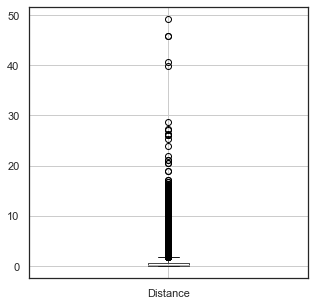

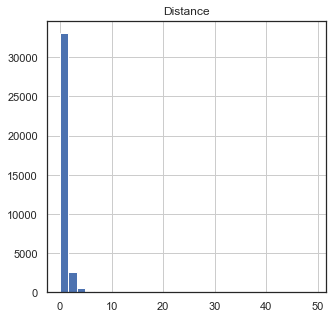

----------------------------------------------------------------
Duration
----------------------------------------------------------------
count     36779.000000
mean        219.106447
std        3607.495386
min           5.000000
25%          41.000000
50%          79.000000
75%         147.000000
max      224923.000000
Name: Duration, dtype: float64


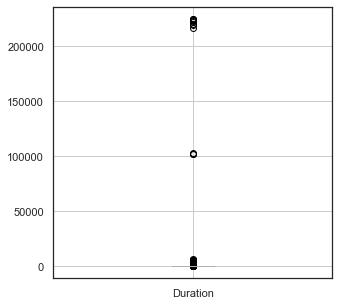

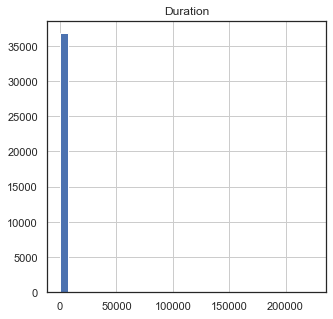

----------------------------------------------------------------
Temp
----------------------------------------------------------------
count    36779.000000
mean        52.531619
std         16.529654
min        -12.000000
25%         40.000000
50%         52.000000
75%         65.000000
max         96.000000
Name: Temp, dtype: float64


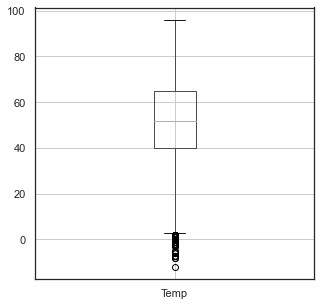

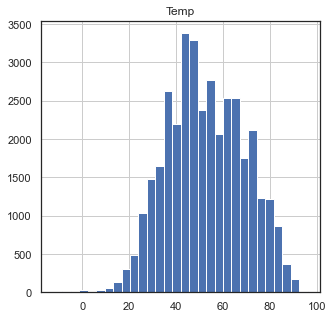

----------------------------------------------------------------
Wind_Chill
----------------------------------------------------------------
count    36779.000000
mean        49.996264
std         19.274810
min        -30.400000
25%         35.000000
50%         52.000000
75%         65.000000
max         96.000000
Name: Wind_Chill, dtype: float64


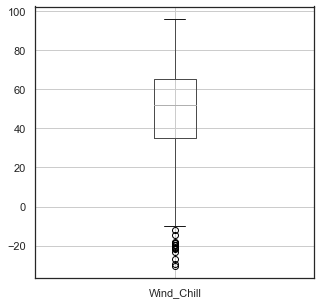

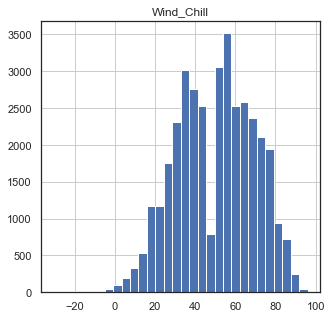

----------------------------------------------------------------
Humidity
----------------------------------------------------------------
count    36779.000000
mean        66.184317
std         20.529978
min         13.000000
25%         50.000000
50%         68.000000
75%         84.000000
max        100.000000
Name: Humidity, dtype: float64


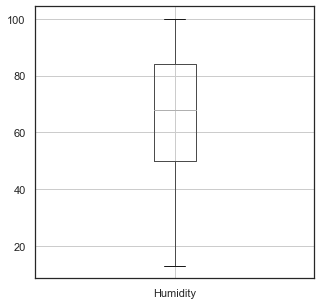

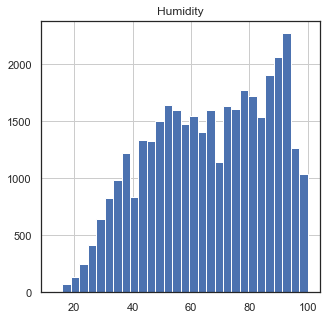

----------------------------------------------------------------
Air_Pressure
----------------------------------------------------------------
count    36779.000000
mean        29.694968
std          0.392098
min         27.550000
25%         29.450000
50%         29.720000
75%         29.970000
max         30.710000
Name: Air_Pressure, dtype: float64


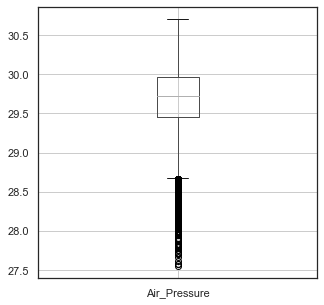

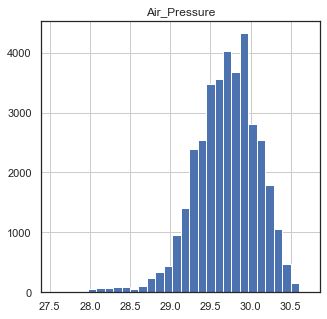

----------------------------------------------------------------
Vis
----------------------------------------------------------------
count    36779.000000
mean         9.025043
std          2.684075
min          0.000000
25%         10.000000
50%         10.000000
75%         10.000000
max         20.000000
Name: Vis, dtype: float64


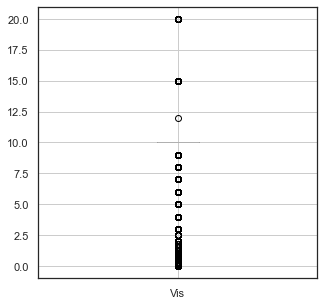

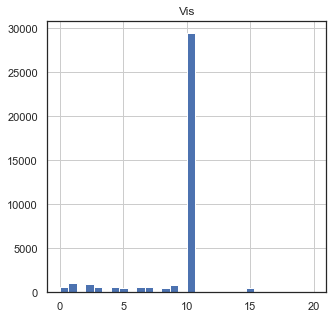

----------------------------------------------------------------
Wind_Speed
----------------------------------------------------------------
count    36779.000000
mean         9.073088
std          5.862613
min          0.000000
25%          5.000000
50%          8.000000
75%         13.000000
max         40.000000
Name: Wind_Speed, dtype: float64


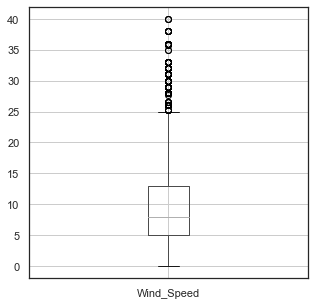

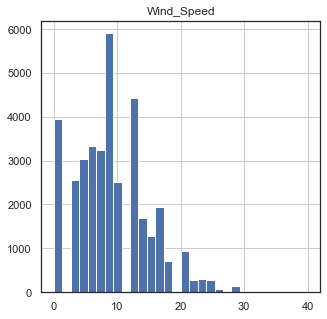

----------------------------------------------------------------
Precip
----------------------------------------------------------------
count    36779.000000
mean         0.005278
std          0.027599
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.830000
Name: Precip, dtype: float64


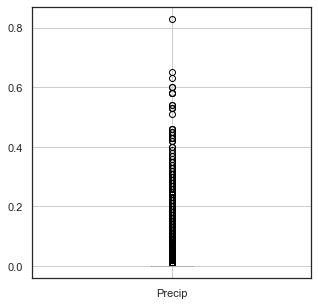

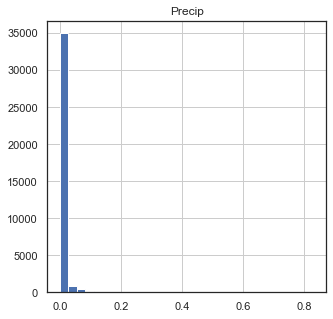

----------------------------------------------------------------


In [12]:
# Visualize data using boxplots, as well as displaying mean, standard deviation, min, max, and quartiles
num_var_list = ('Distance', 'Duration', 'Temp', 'Wind_Chill', 'Humidity', 'Air_Pressure', 'Vis', 'Wind_Speed', 'Precip')
for i in num_var_list:
    print(i)
    print('----------------------------------------------------------------')
    print(df_inc[i].describe())
    df_inc.boxplot(i, figsize = (5, 5))
    df_inc.hist(i, bins = 30,figsize = (5, 5))
    plt.show()
    print('----------------------------------------------------------------')

## Summary table of minimum, maximum, median, mode, quantiles, mean, and standard deviation for numerical variables

In [13]:
# Create list of numerical variables
num_var_list = ['Distance', 'Duration', 'Temp', 'Wind_Chill', 'Humidity', 'Air_Pressure', 'Vis', 'Wind_Speed', 'Precip']

# Create custom functions for calculating quantiles and mode
def Q1(x):
    quantile1 = x.quantile(0.25)
    return quantile1

def Q3(x):
    quantile3 = x.quantile(0.75)
    return quantile3

def IQR(x):
    iqr = Q3(x) - Q1(x)
    return iqr

def mode(x):
    m = Counter(x).most_common(1)[0][0]
    return m

def mode_frequency(x):
    f = (Counter(x).most_common(1)[0][1])/len(x)
    return f

stats_list = ['min', Q1, 'median', Q3, 'max', IQR, 'mean', 'std', 'var', mode, mode_frequency] # list of basic statistics

# Create list list of stats and print to console
df_inc_stats = df_inc[num_var_list].agg(stats_list)
print(df_inc_stats)

                 Distance      Duration        Temp  Wind_Chill    Humidity  \
min              0.000000  5.000000e+00  -12.000000  -30.400000   13.000000   
Q1               0.000000  4.100000e+01   40.000000   35.000000   50.000000   
median           0.186000  7.900000e+01   52.000000   52.000000   68.000000   
Q3               0.683000  1.470000e+02   65.000000   65.000000   84.000000   
max             49.240000  2.249230e+05   96.000000   96.000000  100.000000   
IQR              0.683000  1.060000e+02   25.000000   30.000000   34.000000   
mean             0.652764  2.191064e+02   52.531619   49.996264   66.184317   
std              1.568438  3.607495e+03   16.529654   19.274810   20.529978   
var              2.459997  1.301402e+07  273.229473  371.518287  421.480002   
mode             0.000000  6.000000e+01   50.000000   50.000000   93.000000   
mode_frequency   0.269882  1.058756e-01    0.025694    0.025667    0.041817   

                Air_Pressure        Vis  Wind_Speed

## Visualizing categorical variables

In [14]:
### Bar plot of incident count by 'Year'

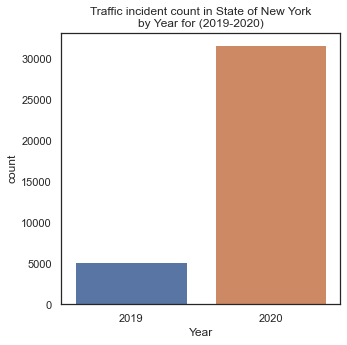

2020    31604
2019     5175
Name: Year, dtype: int64


In [15]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.set_theme(style='white')

# Bar plot of traffic incident count by Day or Night (using Sunrise/Sunset basis)
sns.countplot(x = 'Year', data = df_inc)
plt.title('Traffic incident count in State of New York\nby Year for (2019-2020)')
plt.show()

# Note that most of the data comes from 2020
print(df_inc['Year'].value_counts(0))

### Bar plot of incident count by 'Month'

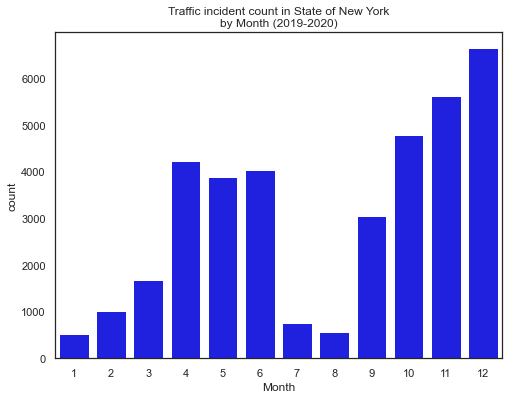

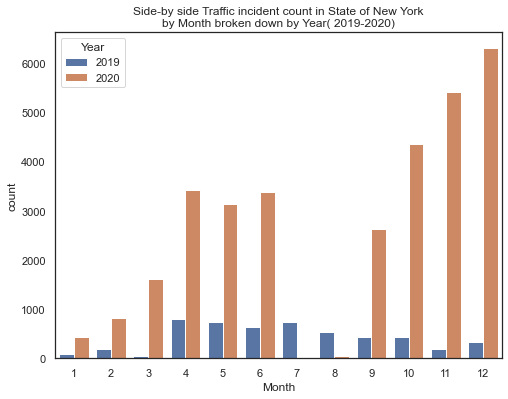

Below are the value counts by Month for the year 2019:
4     799
7     740
5     734
6     639
8     535
10    439
9     427
12    337
2     191
11    186
1      92
3      56
Name: Month, dtype: int64
Below are the value counts by Month for the year 2020:
12    6321
11    5428
10    4351
4     3431
6     3391
5     3147
9     2622
3     1620
2      824
1      424
8       38
7        7
Name: Month, dtype: int64


Month,1,2,3,4,5,6,7,8,9,10,11,12,Total
Year,,,,,,,,,,,,,
2019,92,191,56,799,734,639,740,535,427,439,186,337,5175
2020,424,824,1620,3431,3147,3391,7,38,2622,4351,5428,6321,31604
Total,516,1015,1676,4230,3881,4030,747,573,3049,4790,5614,6658,36779


In [16]:
sns.set(rc={'figure.figsize':(8, 6)})
sns.set_theme(style='white')

# Bar plot of traffic inident count by 'Month'
sns.countplot(x = 'Month', data = df_inc, color = 'blue')
plt.title('Traffic incident count in State of New York\nby Month (2019-2020)')
plt.show()

# Interestingly, there are few traffic incidents from July - August 2020
# Possibly due to COVID-19 restrictions

sns.countplot(x = 'Month', data = df_inc, hue = 'Year')
plt.title('Side-by side Traffic incident count in State of New York\nby Month broken down by Year( 2019-2020)')
plt.show()

# Value counts for 'Month' and cross-table with 'Year'
print('Below are the value counts by Month for the year 2019:')
print(df_inc['Month'][df_inc.Year == 2019].value_counts(0))
print('Below are the value counts by Month for the year 2020:')
print(df_inc['Month'][df_inc.Year == 2020].value_counts(0))

pd.crosstab(df_inc['Year'], df_inc['Month'], margins = True, margins_name = 'Total')

### Bar plot of incident count by 'Hour' of Day

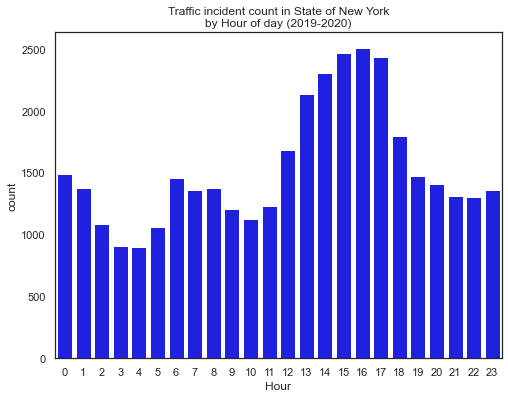

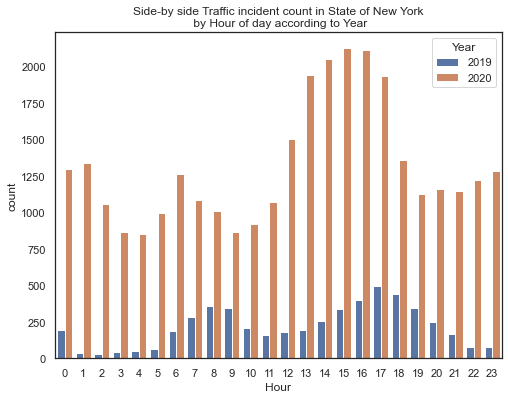

Below are the value counts by Month for the year 2019:
0     192
1      37
2      27
3      40
4      51
5      67
6     190
7     280
8     362
9     346
10    207
11    160
12    179
13    195
14    253
15    336
16    399
17    499
18    440
19    344
20    248
21    167
22     80
23     76
Name: Hour, dtype: int64
Below are the value counts by Month for the year 2020:
0     1301
1     1341
2     1058
3      867
4      849
5      997
6     1265
7     1083
8     1013
9      864
10     922
11    1072
12    1507
13    1945
14    2051
15    2130
16    2113
17    1934
18    1357
19    1127
20    1158
21    1146
22    1221
23    1283
Name: Hour, dtype: int64


Hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,Total
Year,,,,,,,,,,,,,,,,,,,,,
2019,192,37,27,40,51,67,190,280,362,346,...,336,399,499,440,344,248,167,80,76,5175
2020,1301,1341,1058,867,849,997,1265,1083,1013,864,...,2130,2113,1934,1357,1127,1158,1146,1221,1283,31604
Total,1493,1378,1085,907,900,1064,1455,1363,1375,1210,...,2466,2512,2433,1797,1471,1406,1313,1301,1359,36779


In [17]:
# Bar plot of traffic inident count by 'Hour' of day
sns.countplot(x = 'Hour', data = df_inc, color = 'blue')
plt.title('Traffic incident count in State of New York\nby Hour of day (2019-2020)')
plt.show()

sns.countplot(x = 'Hour', data = df_inc, hue = 'Year')
plt.title('Side-by side Traffic incident count in State of New York\n by Hour of day according to Year')
plt.show()

# Value counts for 'Hour' and cross-table with 'Year'
print('Below are the value counts by Month for the year 2019:')
print(df_inc['Hour'][df_inc.Year == 2019].value_counts(0).sort_index())
print('Below are the value counts by Month for the year 2020:')
print(df_inc['Hour'][df_inc.Year == 2020].value_counts(0).sort_index())

pd.crosstab(df_inc['Year'], df_inc['Hour'], margins = True, margins_name = 'Total')

### Change 'Daytime' category to boolean values for later analyses

In [18]:
# Set Daytime to boolean for later analysis
df_inc['Daytime'] = df_inc['Daytime'] == 'Day'

### Bar plot of incident count by Day or Night using Sunrise/Sunset basis

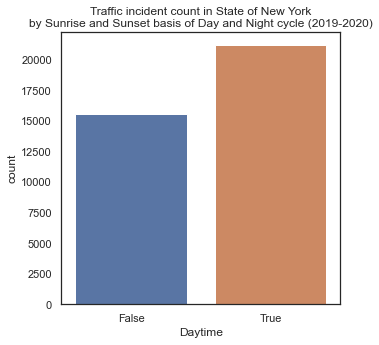

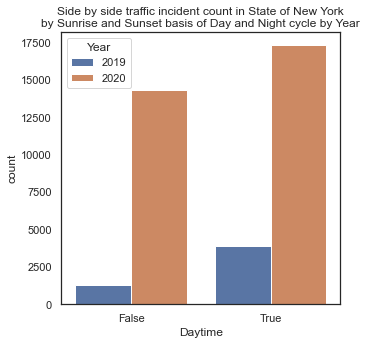

Daytime,False,True,Total
Year,,,
2019,1285,3890,5175
2020,14305,17299,31604
Total,15590,21189,36779


In [19]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.set_theme(style='white')


# Bar plot of traffic incident count by Day or Night (using Sunrise/Sunset basis)
sns.countplot(x = 'Daytime', data = df_inc)
plt.title('Traffic incident count in State of New York\nby Sunrise and Sunset basis of Day and Night cycle (2019-2020)')
plt.show()

# Plot of 'Daytime' by Year and cross-table
sns.countplot(x = 'Daytime', data = df_inc, hue = 'Year')
plt.title('Side by side traffic incident count in State of New York\nby Sunrise and Sunset basis of Day and Night cycle by Year')
plt.show()

pd.crosstab(df_inc['Year'], df_inc['Daytime'], margins = True, margins_name = 'Total')

### Bar plot for incident count by Severity index

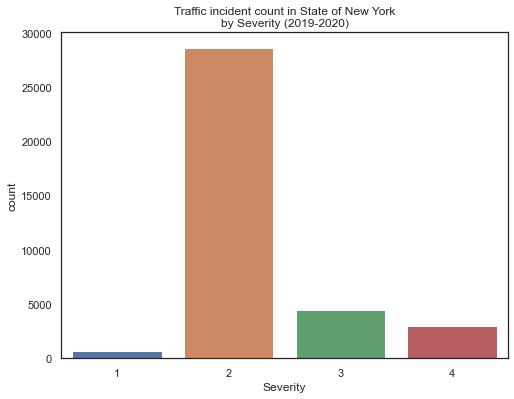

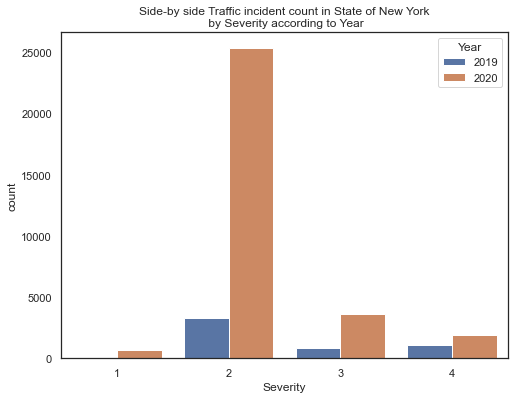

Severity,1,2,3,4,Total
Year,,,,,
2019,0,3280,812,1083,5175
2020,693,25384,3656,1871,31604
Total,693,28664,4468,2954,36779


In [20]:
sns.set(rc={'figure.figsize':(8, 6)})
sns.set_theme(style='white')

# Bar plot of traffic incident count by Severity
sns.countplot(x = 'Severity', data = df_inc)
plt.title('Traffic incident count in State of New York\nby Severity (2019-2020)')
plt.show()

# Note, the most common Severity rating is 2

# Plot of 'Severity' by Year and cross-table
sns.countplot(x = 'Severity', data = df_inc, hue = 'Year')
plt.title('Side-by side Traffic incident count in State of New York\n by Severity according to Year')
plt.show()

pd.crosstab(df_inc['Year'], df_inc['Severity'], margins = True, margins_name = 'Total')

### Bar plot of incident count by 'Weather'

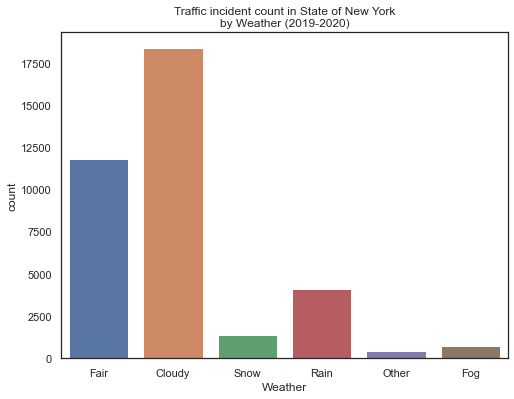

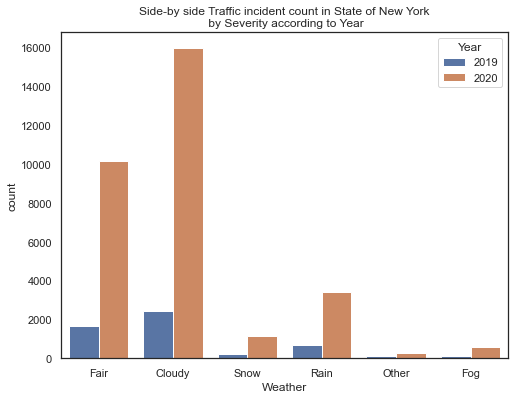

Weather,Cloudy,Fair,Fog,Other,Rain,Snow,Total
Year,,,,,,,
2019,2411,1661,113,115,660,215,5175
2020,15992,10140,603,290,3438,1141,31604
Total,18403,11801,716,405,4098,1356,36779


In [21]:
# Set plot dimensions
sns.set(rc={'figure.figsize':(8, 6)})
sns.set_theme(style='white')

# Bar plot of traffic incident count by Weather
sns.countplot(x = 'Weather', data = df_inc)
plt.title('Traffic incident count in State of New York\nby Weather (2019-2020)')
plt.show()

# Note how most incidents occur in 'Fair' or 'Cloudy' weather, instead of 'Rain' or 'Snow'.
# From this, we can question if weather is relevant to traffic accidence occurence.

# Plot of 'Weather' by Year and cross-table
sns.countplot(x = 'Weather', data = df_inc, hue = 'Year')
plt.title('Side-by side Traffic incident count in State of New York\n by Severity according to Year')
plt.show()

pd.crosstab(df_inc['Year'], df_inc['Weather'], margins = True, margins_name = 'Total')

### Violin plot of Severity by Weather

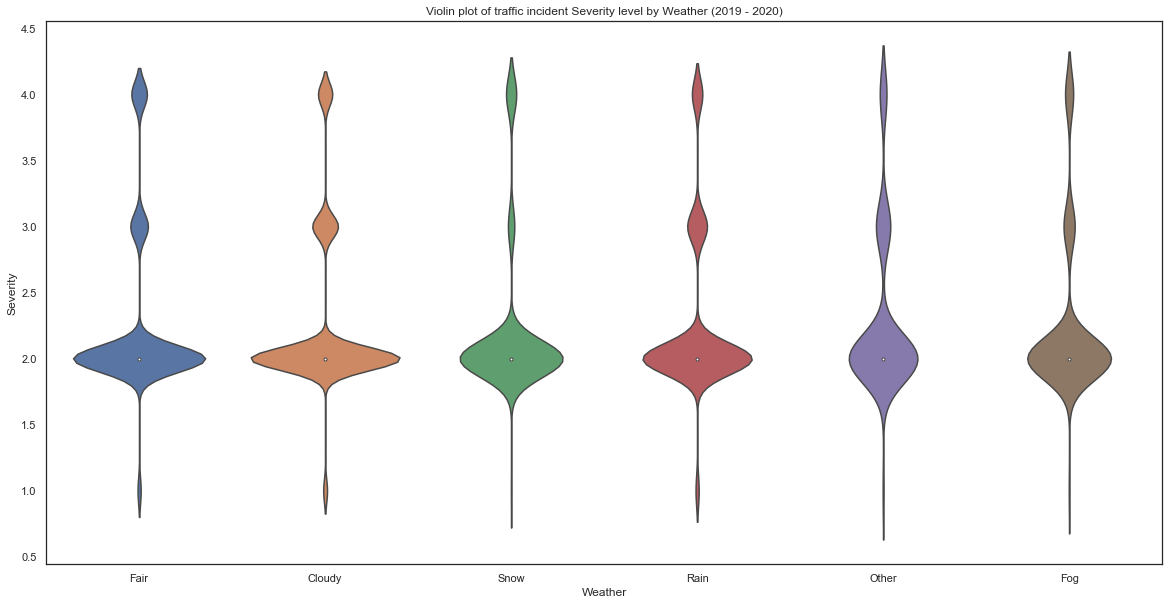

In [22]:
# Violin plot of Severity by Weather
f, ax = plt.subplots(figsize=(20, 10))
sns.violinplot(x=df_inc["Weather"], y=df_inc["Severity"])
plt.title("Violin plot of traffic incident Severity level by Weather (2019 - 2020)")
plt.show()

### Create 'POI_nearby' Point-of-Interest into a boolean category valuable, indicating proximity to a POI within 100 meters

In [23]:
poi_list = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

df_inc['POI_nearby'] = df_inc[poi_list].any(1)

### Bar plot for traffic incident count by presence of POI nearby (within 100 meters)

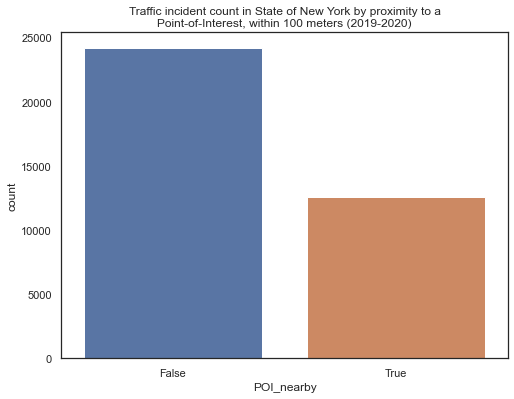

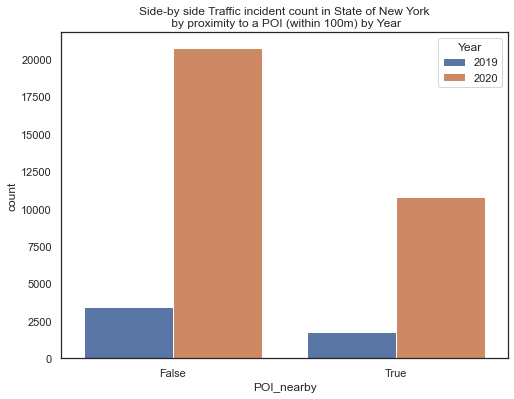

POI_nearby,False,True,Total
Year,,,
2019,3440,1735,5175
2020,20782,10822,31604
Total,24222,12557,36779


In [24]:


sns.countplot(x = 'POI_nearby', data = df_inc)
plt.title('Traffic incident count in State of New York by proximity to a\nPoint-of-Interest, within 100 meters (2019-2020)')
plt.show()

# From a rough visualize estimate, there appears to be twice as many traffic incidents occuring > 100m away from a
# POI (Point-of-Interest). From this, we can question whether proximity to a POI is relevant to traffic incident occurence.

# Plot of 'Severity' by Year and cross-table
sns.countplot(x = 'POI_nearby', data = df_inc, hue = 'Year')
plt.title('Side-by side Traffic incident count in State of New York\n by proximity to a POI (within 100m) by Year')
plt.show()

pd.crosstab(df_inc['Year'], df_inc['POI_nearby'], margins = True, margins_name = 'Total')

### Additional data: which POI's does a traffic incident occur nearby frequently

In [25]:
# Investigate what Points of Interest (POI's) are most frquently near an incident (within 100 meters)
print(df_inc[poi_list].agg('sum'))

Amenity             789
Bump                  2
Crossing           1907
Give_Way            127
Junction           5613
No_Exit              61
Railway             270
Roundabout            2
Station             626
Stop                478
Traffic_Calming       6
Traffic_Signal     5750
Turning_Loop          0
dtype: int64


## Removing rows with zero Distance values

#### Only data with Duration > 0 are of interest

In [26]:
df_size_no_na = df_inc.shape[0]

# Drop rows with zero Distance values
df_inc = df_inc.drop(df_inc[df_inc.Distance == 0].index) # Remove rows with 0 value for 'Distance'

In [27]:
print(f"{df_size_no_na - df_inc.shape[0]} rows with Distance = 0 removed.\n{df_inc.shape[0]} rows remain.") # Only works on initial run of notebook

9926 rows with Distance = 0 removed.
26853 rows remain.


## Correlation coefficients and associated heatmap of numerical variables before removing outliers

,Distance,Duration,Temp,Wind_Chill,Humidity,Air_Pressure,Vis,Wind_Speed,Precip
Distance,1.000000,-0.006274,0.026265,0.023157,-0.019264,-0.077919,-0.007707,0.016494,0.005664
Duration,-0.006274,1.000000,0.007820,0.009179,-0.021640,0.003002,0.009277,-0.004862,-0.005450
Temp,0.026265,0.007820,1.000000,0.989113,-0.244684,0.039387,0.150165,0.000580,0.015432
Wind_Chill,0.023157,0.009179,0.989113,1.000000,-0.213645,0.056917,0.156723,-0.089920,0.012168
Humidity,-0.019264,-0.021640,-0.244684,-0.213645,1.000000,-0.244626,-0.464721,-0.241960,0.205091
Air_Pressure,-0.077919,0.003002,0.039387,0.056917,-0.244626,1.000000,0.121424,-0.119373,-0.084900
Vis,-0.007707,0.009277,0.150165,0.156723,-0.464721,0.121424,1.000000,-0.037767,-0.333338
Wind_Speed,0.016494,-0.004862,0.000580,-0.089920,-0.241960,-0.119373,-0.037767,1.000000,0.068240
Precip,0.005664,-0.005450,0.015432,0.012168,0.205091,-0.084900,-0.333338,0.068240,1.000000


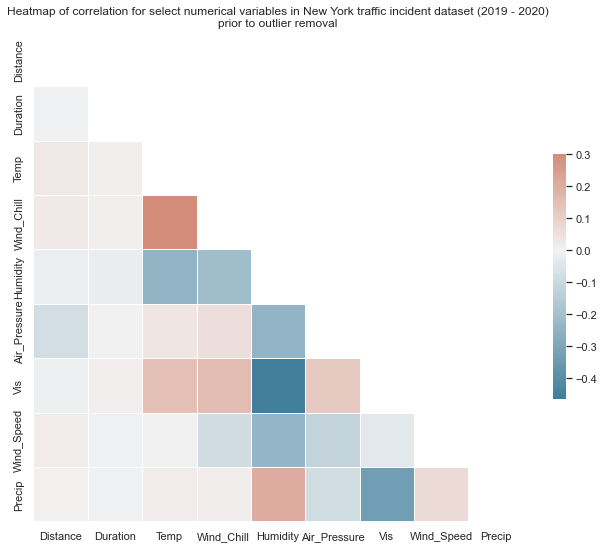

In [28]:
# Code for generating heatmap from: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Generate correlation matrix
corr_matrix = df_inc[num_var_list].corr(method = 'pearson')

# Generate mask for diagonal
diag_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up matplotlib figure and create custom colormap
f, ax = plt.subplots(figsize=(11, 9))
color_map = sns.diverging_palette(230, 20, as_cmap=True)

# Draw figure and print correlation matrix values
sns.heatmap(corr_matrix, mask=diag_mask, cmap=color_map, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title(f"Heatmap of correlation for select numerical variables in New York traffic incident dataset (2019 - 2020)\nprior to outlier removal")


corr_matrix # should be print(corr_matrix), but kept same for viewing on Jupyter Notebook

## Pair plot to visualize relationships between numerical variables

In [29]:
# Pair plot to visualize numerical variables
# Can be commented out due to intensive processing time
# sns.pairplot(df_inc[num_var_list])

## Outliers

### Outlier identification

In [30]:
# Outlier identification
q1_cols = df_inc[num_var_list].apply(Q1)
q3_cols = df_inc[num_var_list].apply(Q3)
iqr_cols = df_inc[num_var_list].apply(IQR)

iqr_m = 1.5 # multiplier for interquantile range threshold, usually 1.5 or 2.2

for i in num_var_list:
    outliers = df_inc[((df_inc[i] < (q1_cols[i] -  iqr_m * iqr_cols[i])) | (df_inc[i] > (q3_cols[i] + iqr_m * iqr_cols[i])))] 
    print(f"Variable \'{i}\' has {outliers.shape[0]} outliers.")
    print(f"Lowest value for outlier is: {outliers[i].min()}")
    print(f"Highest value for outlier is: {outliers[i].max()}")
    print("Outliers are listed below:")
    print(outliers[i])

    print('--------------------------------------------------------------')

Variable 'Distance' has 2422 outliers.
Lowest value for outlier is: 2.209
Highest value for outlier is: 49.24
Outliers are listed below:
10        5.051
13        2.517
20        2.497
35        5.234
38        2.718
          ...  
36650    15.361
36665     6.159
36666     6.159
36696     3.470
36698     2.518
Name: Distance, Length: 2422, dtype: float64
--------------------------------------------------------------
Variable 'Duration' has 2598 outliers.
Lowest value for outlier is: 366
Highest value for outlier is: 224923
Outliers are listed below:
2         926
7        1018
8         473
10        502
11        597
         ... 
30483    5759
30743    5759
30744    5759
32553    5667
32595    5739
Name: Duration, Length: 2598, dtype: int32
--------------------------------------------------------------
Variable 'Temp' has 42 outliers.
Lowest value for outlier is: -12.0
Highest value for outlier is: 0.0
Outliers are listed below:
1472     -1.0
1763     -2.0
2000      0.0
2978      0.

### Using Interquartile range to remove outliers

In [31]:
# Code from https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles/59366409#59366409
q1_cols = df_inc[num_var_list].apply(Q1)
q3_cols = df_inc[num_var_list].apply(Q3)
iqr_cols = df_inc[num_var_list].apply(IQR)

iqr_m = 1.5 # multiplier for interquantile range threshold, usually 1.5 or 2.2
# 2.2 chosen as 1.5 was found to remove many negative values for Temp and other weather - based variables

df_inc_cut = df_inc[~((df_inc[num_var_list] < (q1_cols - iqr_m * iqr_cols)) |(df_inc[num_var_list] > (q3_cols + iqr_m * iqr_cols))).any(axis=1)]
print(f"{df_inc.shape[0] - df_inc_cut.shape[0]} rows of data were removed during outlier removal using interquartile range. {df_inc_cut.shape[0]} rows of data remain after outlier removal.")

10348 rows of data were removed during outlier removal using interquartile range. 16505 rows of data remain after outlier removal.


## Correlation coefficients and associated heatmap of numerical variables after removing outliers

,Distance,Duration,Temp,Wind_Chill,Humidity,Air_Pressure,Vis,Wind_Speed,Precip
Distance,1.000000,-0.045107,0.082169,0.082971,-0.081921,0.021078,NaN,0.025168,NaN
Duration,-0.045107,1.000000,-0.251755,-0.240357,0.152462,-0.009756,NaN,-0.080439,NaN
Temp,0.082169,-0.251755,1.000000,0.990589,-0.237391,-0.044315,NaN,0.070578,NaN
Wind_Chill,0.082971,-0.240357,0.990589,1.000000,-0.203822,-0.027404,NaN,-0.012749,NaN
Humidity,-0.081921,0.152462,-0.237391,-0.203822,1.000000,-0.183194,NaN,-0.339667,NaN
Air_Pressure,0.021078,-0.009756,-0.044315,-0.027404,-0.183194,1.000000,NaN,-0.113314,NaN
Vis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wind_Speed,0.025168,-0.080439,0.070578,-0.012749,-0.339667,-0.113314,NaN,1.000000,NaN
Precip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


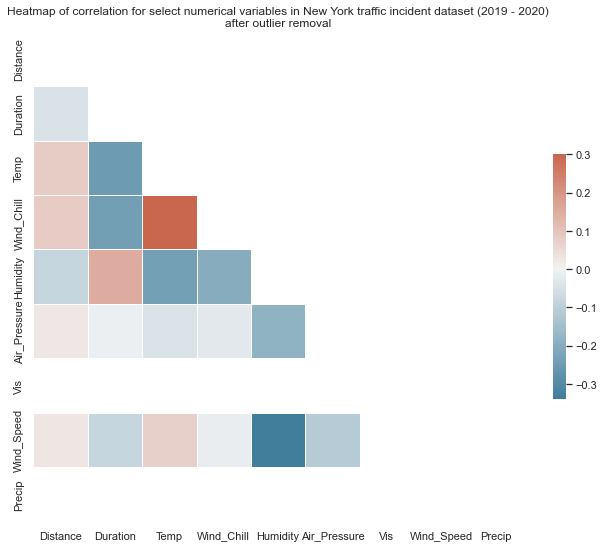

In [32]:
# Generate correlation matrix
corr_matrix_2 = df_inc_cut[num_var_list].corr(method = 'pearson')

# Set up matplotlib figure and create custom colormap
f, ax = plt.subplots(figsize=(11, 9))
color_map = sns.diverging_palette(230, 20, as_cmap=True)

# Draw figure and print correlation matrix values
sns.heatmap(corr_matrix_2, mask=diag_mask, cmap=color_map, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title(f"Heatmap of correlation for select numerical variables in New York traffic incident dataset (2019 - 2020)\nafter outlier removal")


corr_matrix_2 # should be print(corr_matrix), but kept same for viewing on Jupyter Notebook

#### The above method removal has seemed to remove information for rows indicating 'Visibility' and 'Precipitation'. 
#### This is likely due to the abnormal distribution of both variables, with ~80% of Visibility values being 
#### the same value (Vis = 10.0), and ~90% of Precipitation values being zero (Precip = 0.0).

#### As such, Visibility and Precipitation will be excluded from further analyses.

## Remove columns for 'Visibility' and 'Precipitation'

In [33]:
# Remove columns 'Vis' and 'Precip'
drop_labels = ['Vis', 'Precip']

df_inc_cut = df_inc_cut.drop(labels = drop_labels, axis = 1)

## Create Pair plot to visualize correlations between numerical variables after outlier removal

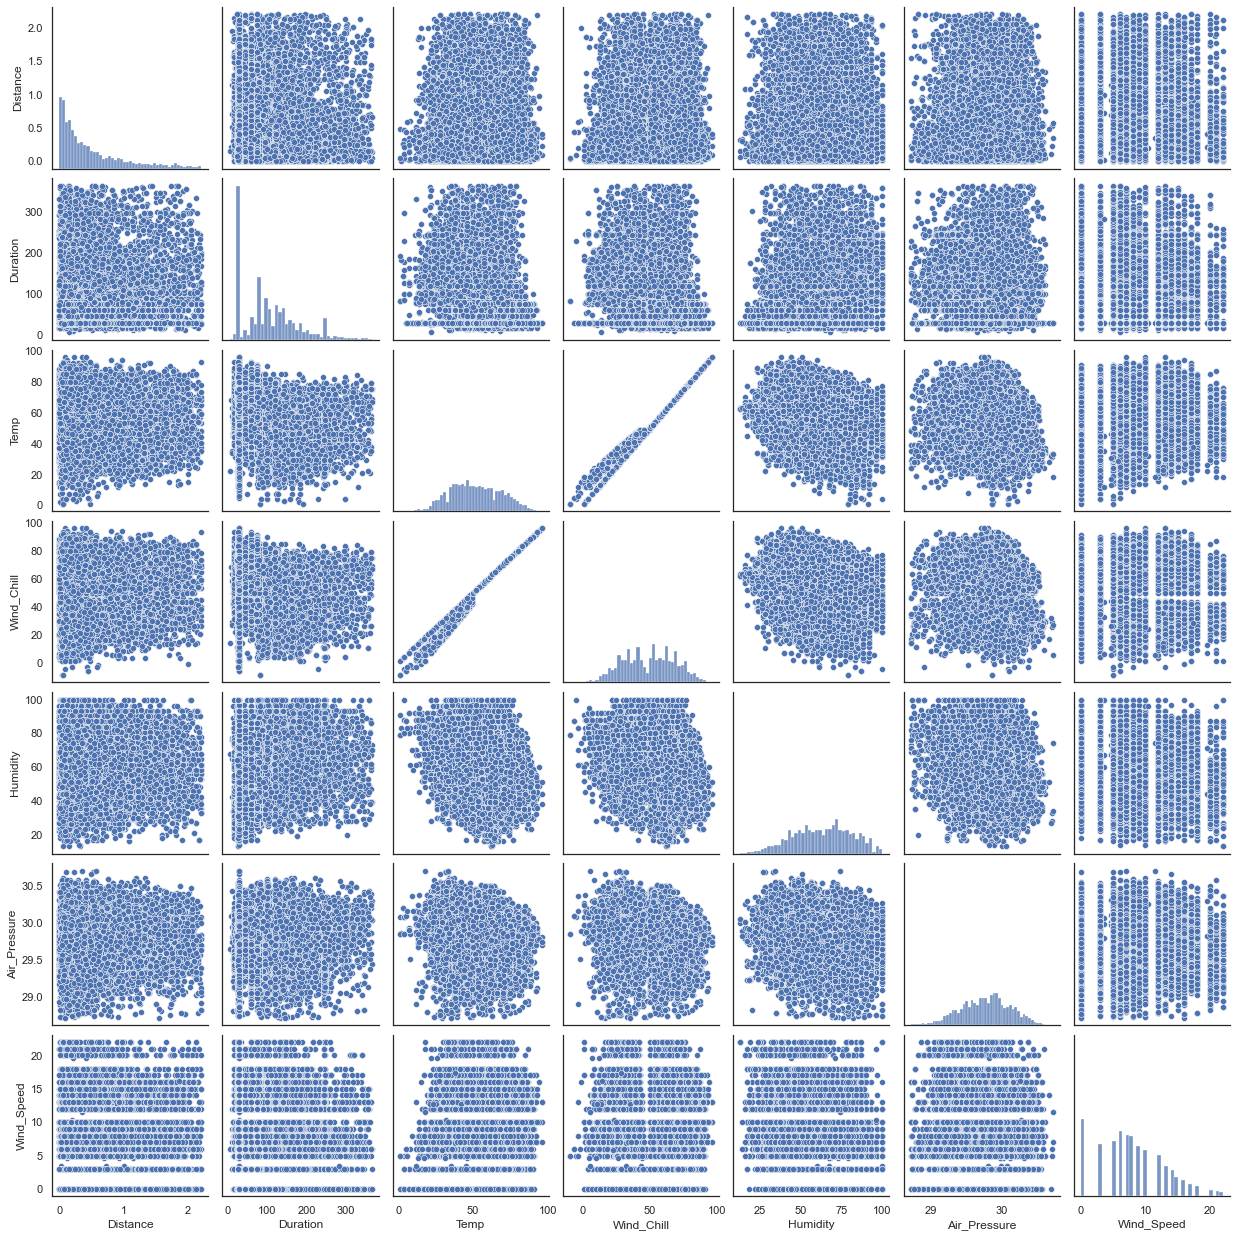

In [34]:
# List of numrical variables still remaining after outlir removal
num_var_list_cut = [var for var in num_var_list if var not in drop_labels]

# Create pair plot of numerical variables after outlier removal
# Can be commented out due to intensive processing time
sns.pairplot(df_inc_cut[num_var_list_cut])

# Statistical Analyses

## Difference in mean incident duration in year 2019 compared to year 2020

### Visualize boxplot of incident duration and summary statistics after outlier removal

count    16505.000000
mean       109.860224
std         73.413221
min          5.000000
25%         34.000000
50%        100.000000
75%        148.000000
max        365.000000
Name: Duration, dtype: float64


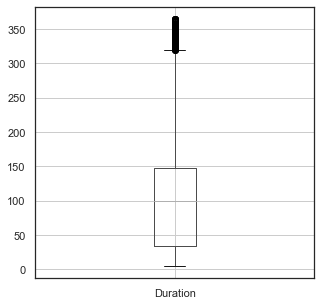

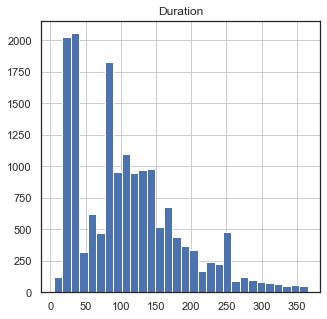

------------------------------------------------


In [35]:
print(df_inc_cut['Duration'].describe())
df_inc_cut.boxplot('Duration', figsize = (5, 5))
df_inc_cut.hist('Duration', bins = 30,figsize = (5, 5))
plt.show()
print('------------------------------------------------')

#### After outlier removal, 'Duration' is still right-skewed

### Levene's test for homogeneity of variance

#### Null hypothesis: Variance in duration of traffic incidents occuring in the year 2019 is the same as year 2020
#### Alternative hypothesis: Variance in duration of traffic incidents occuring in the year 2019 are not the same as year 2020

In [36]:
# Using Levene's test for homogeneity of variance, more robust to departures from normal distributions
test_stat, p_value = stats.levene(df_inc_cut[df_inc_cut['Year'] == 2019]['Duration'],
                                  df_inc_cut[df_inc_cut['Year'] == 2020]['Duration'])

print(f"Using Levene's test, the test statistic is: {test_stat: .4f}\nand the p-value is: {p_value: .4e}.")

Using Levene's test, the test statistic is:  3755.3264
and the p-value is:  0.0000e+00.


#### Checking stats

In [37]:
print("Year 2019")
print(df_inc_cut[df_inc_cut["Year"] == 2019]['Duration'].describe())
print("----------------------------------------------------------------")
print("Year 2020")
print(df_inc_cut[df_inc_cut["Year"] == 2020]['Duration'].describe())

Year 2019
count    3258.000000
mean       30.275936
std        22.435627
min        20.000000
25%        28.000000
50%        28.000000
75%        29.000000
max       314.000000
Name: Duration, dtype: float64
----------------------------------------------------------------
Year 2020
count    13247.000000
mean       129.433381
std         68.193616
min          5.000000
25%         81.000000
50%        120.000000
75%        164.000000
max        365.000000
Name: Duration, dtype: float64


In [38]:
print(f"Sample size: {df_inc_cut.shape[0]}")
print(f"Degrees of freedom: {df_inc_cut.shape[0] - 1}")

Sample size: 16505
Degrees of freedom: 16504


###### The difference in variance for trafic incident Duration between those that occured in the year 2019 (M = 30.28, SD = 22.44)
#### and in the year 2020 (M = 129.43, SD = 68.19) was found to be statistically significant(t(16504) = 3755.326, p < 0.001) using Lavene's test
#### for homoscedasticity.

#### Assumptions for t-test  are:
#### 1. homoscedasticity or homogeneity of variance (non-equal, hence use Welch's t-test)
#### 2. independence(data collected from separate traffic incidents),
#### 3. Normality (Central limit theorem due to high number of samples)

### Welch's t-test for equality of means

#### Null hypothesis: Mean Duration of traffic incidents occuring in the year 2019 is the same as year 2020
#### Alternative hypothesis: Mean duration of traffic incidents occuring in the year 2019 are not the same as year 2020

In [39]:
# Welch's t-test for testing equality of meanns between two groups of unequal variance
test_stat, p_value = stats.ttest_ind(df_inc_cut[df_inc_cut['Year'] == 2019]['Duration'],
                                     df_inc_cut[df_inc_cut['Year'] == 2020]['Duration'],
                                     equal_var = False)

print(f"Using the Welch T-test, the test statistic is: {test_stat: .4f}\nand the p-value is: {p_value: .4e}.")

Using the Welch T-test, the test statistic is: -139.4580
and the p-value is:  0.0000e+00.


##### Analsysis using Welch's t-test for equality of means on the mean Duration of traffic incidents in the 
#### year 2019 (M = 30.28, SD = 22.44) and year 2020 (M = 129.43, SD = 68.19) yields a statistically 
#### significant difference (t(16504) = -139.458, p < 0.001).

#### High value for t-statistic indicates greater difference between mean traffic incident Duration in year 2019 and 2020.

## Difference in mean Duration of traffic incident by different Weather categories

### Checking stats

In [40]:
# Checking standard deviation of duration according to weather category
weather_cat_list = df_inc_cut['Weather'].unique()

for weather in weather_cat_list:
    print(f"Standard deviation of Duration for {weather} Weather category is {df_inc_cut[df_inc_cut['Weather'] == weather]['Duration'].std(axis = 0):.4f}. Number of samples is {df_inc_cut[df_inc_cut['Weather'] == weather].shape[0]}")


Standard deviation of Duration for Fair Weather category is 72.1565. Number of samples is 6947
Standard deviation of Duration for Cloudy Weather category is 74.3848. Number of samples is 9143
Standard deviation of Duration for Rain Weather category is 73.3040. Number of samples is 313
Standard deviation of Duration for Snow Weather category is 60.2350. Number of samples is 51
Standard deviation of Duration for Other Weather category is 51.6432. Number of samples is 42
Standard deviation of Duration for Fog Weather category is 102.6265. Number of samples is 9


In [41]:
# Checking mean of duration according to weather category
for weather in weather_cat_list:
    print(f"Mean duration for {weather} Weather category is {df_inc_cut[df_inc_cut['Weather'] == weather]['Duration'].mean(axis = 0):.4f}. Number of samples is {df_inc_cut[df_inc_cut['Weather'] == weather].shape[0]}")

Mean duration for Fair Weather category is 109.4566. Number of samples is 6947
Mean duration for Cloudy Weather category is 110.4805. Number of samples is 9143
Mean duration for Rain Weather category is 104.2141. Number of samples is 313
Mean duration for Snow Weather category is 121.0196. Number of samples is 51
Mean duration for Other Weather category is 59.6429. Number of samples is 42
Mean duration for Fog Weather category is 158.7778. Number of samples is 9


In [42]:
# Quick Levene's test for homogeneity of variance
test_stat, p_value = stats.levene(df_inc_cut[df_inc_cut['Weather'] == 'Fair']['Duration'],
                                  df_inc_cut[df_inc_cut['Weather'] == 'Cloudy']['Duration'],
                                  df_inc_cut[df_inc_cut['Weather'] == 'Rain']['Duration'],
                                  df_inc_cut[df_inc_cut['Weather'] == 'Fog']['Duration'],
                                  df_inc_cut[df_inc_cut['Weather'] == 'Snow']['Duration'],
                                  df_inc_cut[df_inc_cut['Weather'] == 'Other']['Duration'])

print(f"Using Levene's test, the test statistic F is: {test_stat: .4f}\nand the p-value is: {p_value: .4e}.")

Using Levene's test, the test statistic F is:  5.6612
and the p-value is:  3.2021e-05.


### One-way Analysis of Variance (F-test)

#### Null hypothesis: Mean Duration of traffic incidents for all weather groups are the same
#### Alternative hypothesis: Mean duration of traffic incidents for at least 2 weather groups are not the same

In [43]:
# One-way ANOVA for testing equality of means between groups of N > 2
# F-test for 'Duration' in different 'Weather' categories
test_stat, p_value = stats.f_oneway(df_inc_cut[df_inc_cut['Weather'] == 'Fair']['Duration'],
                                    df_inc_cut[df_inc_cut['Weather'] == 'Cloudy']['Duration'],
                                    df_inc_cut[df_inc_cut['Weather'] == 'Rain']['Duration'],
                                    df_inc_cut[df_inc_cut['Weather'] == 'Fog']['Duration'],
                                    df_inc_cut[df_inc_cut['Weather'] == 'Snow']['Duration'],
                                    df_inc_cut[df_inc_cut['Weather'] == 'Other']['Duration'])

print(f"Using One-way Analysis of Variance, the test statistic F is: {test_stat: .4f}\nand the p-value is: {p_value: .4e}.")

Using One-way Analysis of Variance, the test statistic F is:  5.5156
and the p-value is:  4.4410e-05.


#### One-way Analysis of Variance of traffic incidents under different Weather categories reveals a significant
#### difference in mean duration between 2 or more groups (F(16504) = 5.5156, p < 0.001).

### PostHoc Analysis

In [44]:
post_hoc_tukey = MultiComparison(df_inc_cut['Duration'], df_inc_cut['Weather']).tukeyhsd().summary()
print(post_hoc_tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
Cloudy   Fair  -1.0239    0.9   -4.3517   2.3039  False
Cloudy    Fog  48.2973  0.358   -21.432 118.0266  False
Cloudy  Other -50.8376  0.001  -83.1742 -18.5011   True
Cloudy   Rain  -6.2664 0.6507  -18.2852   5.7524  False
Cloudy   Snow  10.5391    0.9  -18.8202  39.8984  False
  Fair    Fog  49.3212 0.3333   -20.419 119.0613  False
  Fair  Other -49.8137  0.001  -82.1737 -17.4538   True
  Fair   Rain  -5.2425 0.7947   -17.324   6.8389  False
  Fair   Snow   11.563 0.8612   -17.822   40.948  False
   Fog  Other -99.1349 0.0032 -175.9351 -22.3347   True
   Fog   Rain -54.5637 0.2375 -125.2537  16.1262  False
   Fog   Snow -37.7582 0.6868  -113.353  37.8367  False
 Other   Rain  44.5712  0.003   10.2122  78.9302   True
 Other   Snow  61.3768  0.001     17.81 104.9435   True
  Rain   Snow  16.8056 0.6328  -14.7675  48.3786

#### PostHoc Analysis suggests different mean duration of traffic incidents when comparing the following
#### Weather categories pair-wise:
####      - Cloudy and Other
####      - Fair and Other
####      - Fog and Other
####      - Fair and Rain
####      - Other and Rain
####      - Other and Snow


## Difference in median Severity of traffic incidents in different Weather categories

### Check stats

In [45]:
print(df_inc_cut[df_inc_cut['Weather'] == 'Cloudy']['Severity'].median(axis=0))
print(df_inc_cut[df_inc_cut['Weather'] == 'Other']['Severity'].median(axis=0))
print(df_inc_cut[df_inc_cut['Weather'] == 'Snow']['Severity'].median(axis=0))
print(df_inc_cut[df_inc_cut['Weather'] == 'Fair']['Severity'].median(axis=0))
print(df_inc_cut[df_inc_cut['Weather'] == 'Rain']['Severity'].median(axis=0))
print(df_inc_cut[df_inc_cut['Weather'] == 'Snow']['Severity'].median(axis=0))

2.0
2.0
2.0
2.0
2.0
2.0


### Visualize data with a violin plot

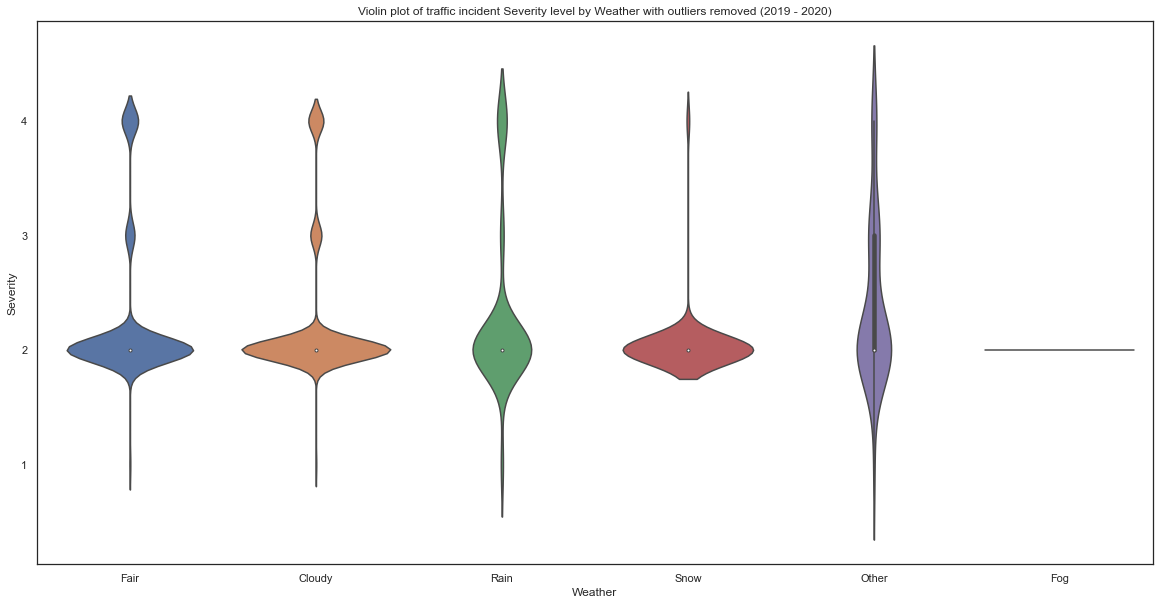

In [46]:
# Violin plot of Severity by Weather
f, ax = plt.subplots(figsize=(20, 10))
sns.violinplot(x=df_inc_cut["Weather"], y=df_inc_cut["Severity"])
plt.title("Violin plot of traffic incident Severity level by Weather with outliers removed (2019 - 2020)")
plt.show()

### Kruskal-Wallis H-test to test equality of medians

<AxesSubplot:xlabel='Distance', ylabel='Count'>

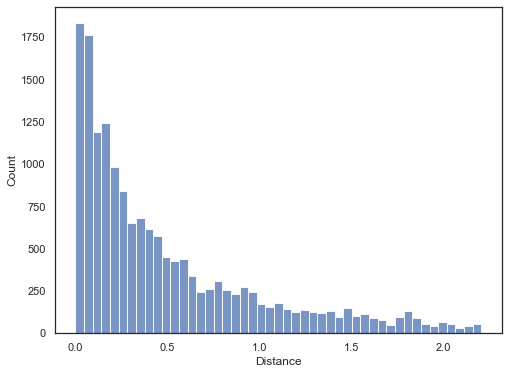

In [47]:
sns.histplot(x = 'Distance', data = df_inc_cut)

#### Null hypothesis: Median Severity level of traffic incidents for all weather groups are the same
#### Alternative hypothesis: Median Severity level of traffic incidents for at least 2 weather groups are not the same

In [48]:
# Kruskal-Wallis H-Test to test equality of medians for Weather by Severity, as Severity is ordinal in nature
test_stat, p_value = stats.kruskal(df_inc_cut[df_inc_cut['Weather'] == 'Fair']['Severity'],
                                   df_inc_cut[df_inc_cut['Weather'] == 'Cloudy']['Severity'],
                                   df_inc_cut[df_inc_cut['Weather'] == 'Rain']['Severity'],
                                   df_inc_cut[df_inc_cut['Weather'] == 'Fog']['Severity'],
                                   df_inc_cut[df_inc_cut['Weather'] == 'Snow']['Severity'],
                                   df_inc_cut[df_inc_cut['Weather'] == 'Other']['Severity'])

print(f"Using the Kruskal-Wallis H-test, the H test statistic is: {test_stat: .4f}\nand the p-value is: {p_value: .4e}.")

Using the Kruskal-Wallis H-test, the H test statistic is:  23.2927
and the p-value is:  2.9673e-04.


In [49]:
# Check stats
print(f"Number of unique categories: {len(df_inc_cut['Weather'].unique())}")
print(f"Degrees of freedom: {len(df_inc_cut['Weather'].unique()) - 1}")

Number of unique categories: 6
Degrees of freedom: 5


#### Using Kruskal-Wallis H-test, a statistically significant difference was found in Severity levels
#### for traffic incidents under different Weather category classifications ($Chi^{2}$(5, 16504) = 23.292, p < 0.001).

### Pair-wise Mann-Whitney U-Tests

In [50]:
# Conduct Pairwise Mann-Whitney U-tests to detrmine which groups have statistically significant difference in median

pairwise_utest = MultiComparison(df_inc_cut['Severity'], df_inc_cut['Weather']).allpairtest(stats.mannwhitneyu, method='Holm')
print(pairwise_utest[0])

Test Multiple Comparison mannwhitneyu 
FWER=0.05 method=Holm
alphacSidak=0.00, alphacBonf=0.003
group1 group2    stat     pval  pval_corr reject
------------------------------------------------
Cloudy   Fair 31140963.5 0.0005    0.0068   True
Cloudy    Fog    35181.0 0.1147    0.6001  False
Cloudy  Other   166922.5 0.0099     0.109  False
Cloudy   Rain  1412381.5  0.268    0.8041  False
Cloudy   Snow   204200.0 0.0072    0.0858  False
  Fair    Fog    26176.5    0.1    0.6001  False
  Fair  Other   130121.5 0.0336    0.3027  False
  Fair   Rain  1080832.0 0.3953    0.8041  False
  Fair   Snow   151998.5 0.0039    0.0507  False
   Fog  Other      135.0 0.0456    0.3647  False
   Fog   Rain     1197.0 0.1367    0.6001  False
   Fog   Snow      225.0 0.3544    0.8041  False
 Other   Rain     5867.0   0.06    0.4197  False
 Other   Snow      790.0 0.0004    0.0053   True
  Rain   Snow     6942.5 0.0131    0.1312  False
------------------------------------------------


#### Group pairings with differing median Severity levels:
####      - Cloudy and Fair
####      - Other and Snow


# Linear Regression

## Duration vs Distance

In [51]:
# Generate model and print summary table
line_mod_1 = smf.ols('Duration ~ Distance', data = df_inc_cut)
res_1 = line_mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:               Duration   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     33.65
Date:                Wed, 11 May 2022   Prob (F-statistic):           6.73e-09
Time:                        17:12:36   Log-Likelihood:                -94309.
No. Observations:               16505   AIC:                         1.886e+05
Df Residuals:                   16503   BIC:                         1.886e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    113.1104      0.800    141.403      0.0

## Duration vs Severity (as a category)

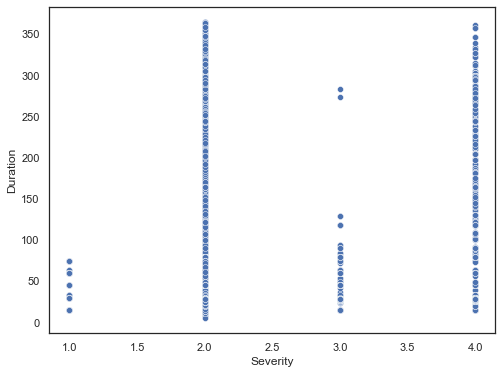

In [52]:
sns.scatterplot(x = 'Severity', y = 'Duration', data = df_inc_cut)
plt.show()

In [53]:
# Create column 'Severity_cat' which treats Severity as category data type
df_inc_cut['Severity_cat'] = df_inc_cut['Severity'].astype('category')

# Generate model and print summary table
line_mod_2 = smf.ols('Duration ~ Severity_cat', data = df_inc_cut)
res_2 = line_mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Duration   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     675.5
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        17:12:36   Log-Likelihood:                -93370.
No. Observations:               16505   AIC:                         1.867e+05
Df Residuals:                   16501   BIC:                         1.868e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            50.6818      7.38

## Multilinear regression

In [54]:
# Generate model and print summary table
line_mod_3 = smf.ols('Duration ~ Distance + Temp + Humidity + Air_Pressure', data = df_inc_cut)
res_3 = line_mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:               Duration   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     324.0
Date:                Wed, 11 May 2022   Prob (F-statistic):          7.12e-269
Time:                        17:12:36   Log-Likelihood:                -93702.
No. Observations:               16505   AIC:                         1.874e+05
Df Residuals:                   16500   BIC:                         1.875e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      148.9433     49.566      3.005   

# Predictive modelling

In [55]:
df_inc_cut = df_inc_cut.drop('Severity_cat', axis = 1)
dfpreds = df_inc_cut.replace([True, False], [1,0])

In [56]:
# Code if Severity treated as an ordinal variable

dfpreds = pd.get_dummies(dfpreds, drop_first=True)

dfpreds = df_inc_cut.replace([True, False], [1,0])
df_int = dfpreds.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df_float = dfpreds.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
dfpreds = pd.concat([dfpreds.select_dtypes(include=['uint8']),df_int,df_float,],axis=1)
dfpreds['Severity'] = df_inc['Severity'].astype('category')
# Remove any unecessary / correlated columns
drop_labels = ['Wind_Chill']
dfpreds = dfpreds.drop(labels = drop_labels, axis = 1)
dfpreds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16505 entries, 0 to 36778
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Severity         16505 non-null  category
 1   Amenity          16505 non-null  uint8   
 2   Bump             16505 non-null  uint8   
 3   Crossing         16505 non-null  uint8   
 4   Give_Way         16505 non-null  uint8   
 5   Junction         16505 non-null  uint8   
 6   No_Exit          16505 non-null  uint8   
 7   Railway          16505 non-null  uint8   
 8   Roundabout       16505 non-null  uint8   
 9   Station          16505 non-null  uint8   
 10  Stop             16505 non-null  uint8   
 11  Traffic_Calming  16505 non-null  uint8   
 12  Traffic_Signal   16505 non-null  uint8   
 13  Turning_Loop     16505 non-null  uint8   
 14  Daytime          16505 non-null  uint8   
 15  Year             16505 non-null  uint16  
 16  Month            16505 non-null  uint8  

In [57]:
# # Code if Severity treated as a category

# dfpreds = pd.get_dummies(dfpreds, drop_first=True)
# dfpreds = df_inc_cut.replace([True, False], [1,0])
# df_int = dfpreds.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
# df_float = dfpreds.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
# dfpreds = pd.concat([dfpreds.select_dtypes(include=['uint8']),df_int,df_float, dfpreds['Severity']],axis=1)
# dfpreds['Severity'] = df_inc['Severity'].astype('category')
# # Remove any unecessary / correlated columns
# drop_labels = ['Wind_Chill']
# dfpreds = dfpreds.drop(labels = drop_labels, axis = 1)
# dfpreds.info()

In [58]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn import tree
import statsmodels.api as sm
from sklearn import metrics

## Logistic regression

In [59]:
# Assign the data
df = dfpreds

# Set the target for the prediction
target = 'Severity'

# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

In [60]:
# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Decision tree','Random Forest', 'Random Forest Limited']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]

In [61]:
# Logistic regression
lr = LogisticRegression(solver='lbfgs', random_state=0, max_iter=10000, multi_class='auto')
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score of y pred against y
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("Logistic regression accuracy is: {:.3f}.".format(acc))

Logistic regression accuracy is: 0.838.


In [62]:
print('intercept', lr.intercept_[0])
print('classes', lr.classes_)
pd.DataFrame({'Coefficients': lr.coef_[0]}, 
             index=X.columns)

lr.predict_proba(X)

intercept -0.0004072231463108777
classes [1 2 3 4]


array([[6.54925749e-05, 9.72589276e-01, 4.56784747e-03, 2.27773838e-02],
       [1.74523646e-03, 7.66336222e-01, 1.67040097e-01, 6.48784444e-02],
       [1.18192619e-04, 9.59859221e-01, 8.04166305e-03, 3.19809236e-02],
       ...,
       [2.61127371e-03, 8.00229708e-01, 1.57709620e-01, 3.94493976e-02],
       [1.62368373e-02, 6.24151421e-01, 2.21890380e-01, 1.37721362e-01],
       [5.39699013e-03, 7.08542502e-01, 1.81354148e-01, 1.04706361e-01]])

In [63]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[   0,   15,    0,    2],
       [   0, 2722,    1,   40],
       [   0,  181,    1,   23],
       [   0,  272,    1,   43]], dtype=int64)

Text(0.5, 384.16, 'Predicted label')

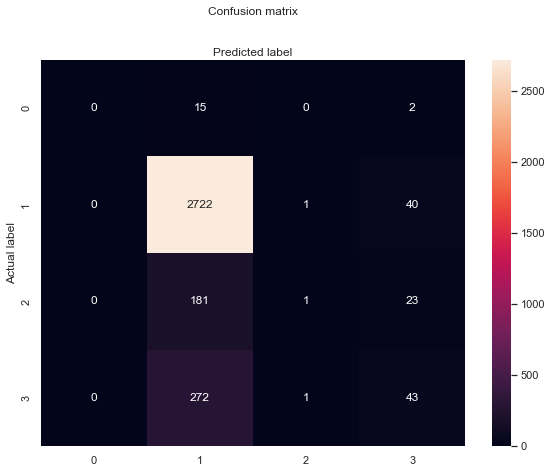

In [64]:
class_names=[1,2,3,4] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [65]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='weighted'))

Accuracy: 0.8379279006361708
Precision: 0.7730362503043717
Recall: 0.8379279006361708


C:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNN classification

In [66]:
# Create a k-NN classifier with a randomly selected NN=
knn = KNeighborsClassifier(n_neighbors=8)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print('KNN score is: {:.3f}.'.format(knn.score(X_test, y_test)))
print('KNN accuracy is: {:.3f}.'.format(acc))

KNN score is: 0.852.
KNN accuracy is: 0.852.


### KNN with CV

Selected a random value for k

In [67]:
#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=8)
#train model with cv of 5 
cv_scores = cross_val_score(knn, X, y, cv=10)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.8413083  0.85584494 0.85645064 0.84191399 0.8407026  0.84545455
 0.84909091 0.84121212 0.37575758 0.32727273]
cv_scores mean:0.7475008351228825


### KNN with grid search CV

Using sklearn.model_selection GridSearchCV for cross-validation to select k

In [68]:
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 20)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5, scoring='accuracy')
#fit model to data
knn_gscv.fit(X, y)
print('KNN best score is: {}.'.format(knn_gscv.best_score_))
print('KNN optimal k value is: {}.'.format(knn_gscv.best_params_))

KNN best score is: 0.7065737655255983.
KNN optimal k value is: {'n_neighbors': 12}.


In [69]:
knn_gscv.cv_results_  # get KNN cv results

{'mean_fit_time': array([0.00360017, 0.0035006 , 0.00360026, 0.00360007, 0.00350065,
        0.00379982, 0.00360007, 0.00339985, 0.00349965, 0.00349965,
        0.00350008, 0.0036005 , 0.00349946, 0.0035008 , 0.00370002,
        0.00340023, 0.00349975, 0.00360022, 0.0034936 ]),
 'std_fit_time': array([1.99416093e-04, 9.36836372e-07, 2.00201238e-04, 1.99938816e-04,
        4.10190833e-07, 2.44717577e-04, 1.99938076e-04, 1.99796306e-04,
        6.50319180e-07, 2.43140197e-07, 6.32595976e-07, 1.99962366e-04,
        5.51978917e-07, 6.32595976e-07, 4.00306001e-04, 1.99985675e-04,
        6.91002691e-07, 2.01416411e-04, 1.38647322e-05]),
 'mean_score_time': array([0.62369971, 0.65619955, 0.69780021, 0.7829    , 0.79069982,
        0.8131    , 0.82070045, 0.82199979, 0.7907002 , 0.78129959,
        0.77449999, 0.78029952, 0.7859004 , 0.76239944, 0.7580997 ,
        0.77159986, 0.76300015, 0.76560631, 0.76529946]),
 'std_score_time': array([0.03516672, 0.02425984, 0.02773759, 0.0320969 , 0.03

### Decision tree 

Decision tree with entropy info criterion

In [70]:
# Decision tree algorithm

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)

# Print accuracy_gini
print('Decision Tree accuracy with gini index: {:.3f}.'.format(accuracy_gini))

[Decision Tree -- entropy] accuracy_score: 0.869.
Decision Tree accuracy with gini index: 0.869.


In [71]:
list(dfpreds)

['Severity',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Daytime',
 'Year',
 'Month',
 'Hour',
 'Duration',
 'POI_nearby',
 'Distance',
 'Temp',
 'Humidity',
 'Air_Pressure',
 'Wind_Speed']

C:\Users\Owner\AppData\Local\Temp/ipykernel_16740/3184055927.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfpreds.feature_names = list(dfpreds)


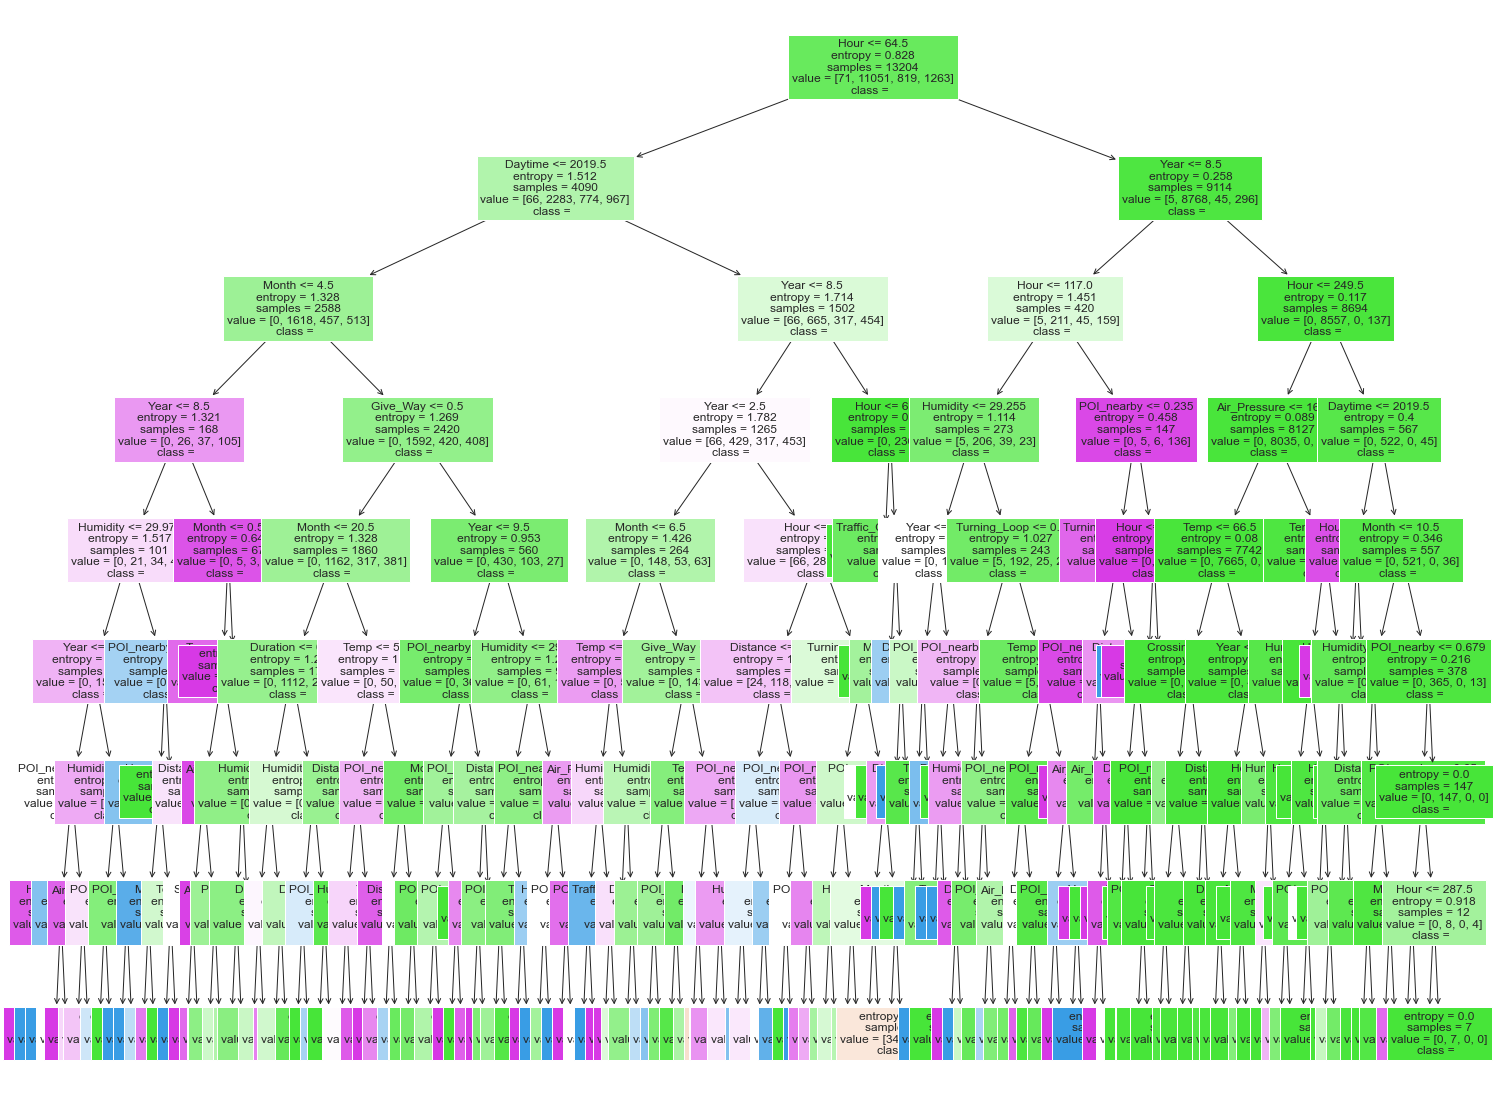

In [72]:
# decision tree visualisation plot
dfpreds.feature_names = list(dfpreds)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_entropy, 
                   feature_names=dfpreds.feature_names,  
                   class_names=str(dfpreds['Severity']),
                   filled=True,fontsize=12)
plt.savefig('tree.png',format='png',bbox_inches = "tight")

In [73]:
# decision tree text representation of features
text_representation = tree.export_text(dt_entropy)
print(text_representation)
with open("decision_tree.log", "w") as fout:
    fout.write(text_representation)

|--- feature_17 <= 64.50
|   |--- feature_14 <= 2019.50
|   |   |--- feature_16 <= 4.50
|   |   |   |--- feature_15 <= 8.50
|   |   |   |   |--- feature_22 <= 29.97
|   |   |   |   |   |--- feature_15 <= 4.50
|   |   |   |   |   |   |--- feature_19 <= 0.19
|   |   |   |   |   |   |   |--- feature_17 <= 28.50
|   |   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |   |--- feature_17 >  28.50
|   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |--- feature_19 >  0.19
|   |   |   |   |   |   |   |--- feature_16 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |--- feature_16 >  0.50
|   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- feature_15 >  4.50
|   |   |   |   |   |   |--- feature_22 <= 29.54
|   |   |   |   |   |   |   |--- feature_23 <= 4.00
|   |   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |   |--- feature_23 >  4.00
|   |   |   |   |   |   |   |   |--- class: 4
|   |   |   

### Random forest

Random forest with default 100 trees

In [74]:
# Random Forest algorithm

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)


# Model Accuracy, how often is the classifier correct?
print("Random forest accuracy : {:.3f}.".format(acc))

Random forest accuracy : 0.913.


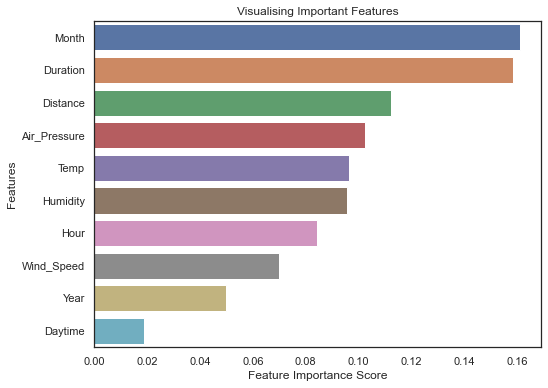

In [75]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualising Important Features")
plt.show()

In [76]:
# List top k important features
k=20
feature_imp.sort_values(ascending=False)[:k]

Month             0.160981
Duration          0.158509
Distance          0.112459
Air_Pressure      0.102431
Temp              0.096387
Humidity          0.095586
Hour              0.084388
Wind_Speed        0.070009
Year              0.049880
Daytime           0.018796
Junction          0.011478
POI_nearby        0.010449
Traffic_Signal    0.009460
Crossing          0.005433
Station           0.003370
Amenity           0.003369
Stop              0.003217
Railway           0.002247
Give_Way          0.001513
No_Exit           0.000032
dtype: float64

In [77]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_train)

feat_labels=X.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Year
Month
Hour
Duration
Distance
Temp
Humidity
Air_Pressure
Wind_Speed


In [78]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [79]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print('[Randon forest algorithm -- Full feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
print('[Randon forest algorithm -- Limited feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

# Get the accuracy score
acc=accuracy_score(y_test, y_important_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

[Randon forest algorithm -- Full feature] accuracy_score: 0.913.
[Randon forest algorithm -- Limited feature] accuracy_score: 0.919.


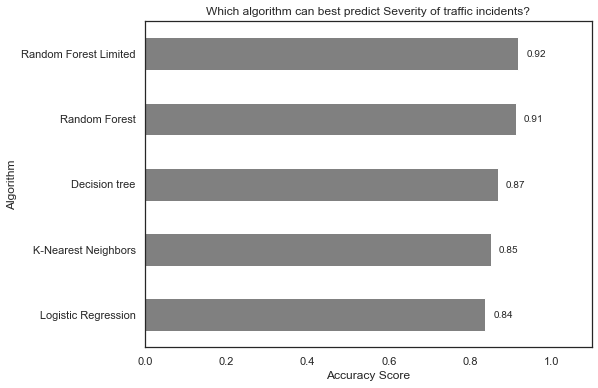

In [80]:
# Make a plot of the accuracy scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)


# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

# Set the limit, lables, ticks and title
plt.xlim(0,1.1)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('Which algorithm can best predict Severity of traffic incidents?')

plt.show()